In [1]:
import nltk, gensim, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from scipy import stats

sns.set_context('talk')

### Loading and inspecting the dataset

In [2]:
#Instantiate DataFrame of craigslist data

listings_df = pd.read_csv('..\\data\\CRAIGSLIST.Listings-1.csv')

In [3]:
# Function to print dataframe columns in a readable format

def format_columns(df):
    print("Columns:")
    for column in df.columns:
        print(column)

In [4]:
format_columns(listings_df)

Columns:
LISTING_ID
LISTING_MONTH
LISTING_DAY
LISTING_TIME
RETRIEVED_ON
BODY
PRICE
AREA_SQFT
ALLOWS_CATS
ALLOWS_DOGS
ADDRESS
LOCATION
CT_ID_10


In [5]:
listings_df.RETRIEVED_ON.min()

'2020-04-26T19:18:00+00:00'

In [6]:
listings_df.RETRIEVED_ON.max()

'2021-01-18T17:21:54+00:00'

#### The dataset includes listings that were active on the site from 01/18/2020 through 04/26/2020. The 'RETRIEVED_ON' column will no longer be needed for this dataset.

#### Because this tool is intended to be used with a snapshot of current listing data, ['LISTING_MONTH', 'LISTING_DAY, 'LISTING_TIME'] are not relevant.  

#### The location data contained in ['ADDRESS', 'LOCATION', 'CT_ID_10'] are outside the current scope of this project. Despite being particularly important for real estate, the vast majority of goods and services offered on craigslist are filtered by location as much as necessary by user location selection.

In [7]:
#Drop unnecessary columns from feature set

listings_df.drop(['LISTING_MONTH',
               'LISTING_DAY',
               'LISTING_TIME',
               'RETRIEVED_ON',
               'ADDRESS',
               'LOCATION',
               'CT_ID_10'],
              axis =1,
              inplace = True)

In [8]:
format_columns(listings_df)

Columns:
LISTING_ID
BODY
PRICE
AREA_SQFT
ALLOWS_CATS
ALLOWS_DOGS


In [9]:
unique_IDs = listings_df.LISTING_ID.nunique()
row_count = listings_df.shape[0]
excess = row_count - unique_IDs

print('Unique Listing IDs:', unique_IDs)
print('Rows in DataFrame:', row_count)
print('Excess Rows:', excess)
print('Percentage of Dataset that is Excess:', round(excess/row_count, 4) * 100)

Unique Listing IDs: 129409
Rows in DataFrame: 134854
Excess Rows: 5445
Percentage of Dataset that is Excess: 4.04


#### There are 5,445 observations in the dataset that contain duplicate IDs. Duplicates will be dropped in favor of the more recent listing

In [10]:
listings_df.drop_duplicates(subset = ['LISTING_ID'], inplace = True, keep = 'last')

In [11]:
unique_IDs = listings_df.LISTING_ID.nunique()
row_count = listings_df.shape[0]
excess = row_count - unique_IDs

print('Unique Listing IDs:', unique_IDs)
print('Rows in DataFrame:', row_count)
print('Excess Rows:', excess)
print('Percentage of Dataset that is Excess:', round(excess/row_count, 4) * 100)

Unique Listing IDs: 129409
Rows in DataFrame: 129409
Excess Rows: 0
Percentage of Dataset that is Excess: 0.0


#### 'LISTING_ID' will now be used as the index of the DataFrame

In [12]:
listings_df.set_index('LISTING_ID', drop = True, inplace = True)

In [13]:
listings_df.describe()

,PRICE,AREA_SQFT,ALLOWS_CATS,ALLOWS_DOGS
count,129409.000000,5.266000e+04,126885.000000,126885.000000
mean,2007.589604,1.447529e+03,0.559089,0.367853
std,898.619447,4.458312e+04,0.496498,0.482223
min,10.000000,0.000000e+00,0.000000,0.000000
25%,1400.000000,7.200000e+02,0.000000,0.000000
50%,1875.000000,9.340000e+02,1.000000,0.000000
75%,2498.000000,1.191000e+03,1.000000,1.000000
max,7000.000000,7.001500e+06,1.000000,1.000000


In [14]:
print('Current number of rows in DataFrame:', listings_df.shape[0])

Current number of rows in DataFrame: 129409


#### The missing data in the pet-related and 'AREA_SQFT' columns need to be accounted for.

In [15]:
missing_pet_data_count = listings_df.shape[0] - sum(listings_df.ALLOWS_CATS.notnull())
print('Observations with missing pet data:', missing_pet_data_count)
print('Percent of original dataset:', round(missing_pet_data_count/row_count, 4) * 100)

Observations with missing pet data: 2524
Percent of original dataset: 1.95


In [16]:
missing_area_data_count = listings_df.shape[0] - sum(listings_df.AREA_SQFT.notnull())
print('Observations with missing pet data:', missing_area_data_count)
print('Percent of original dataset:', round(missing_area_data_count/row_count, 4) * 100)

Observations with missing pet data: 76749
Percent of original dataset: 59.309999999999995


#### Because the observations with missing pet-related data compose only 1.95% of the dataset, those observations will be removed.

In [17]:
#Drop rows without pet data

listings_df = listings_df[listings_df.ALLOWS_CATS.notnull()]

#### However, over half of the observations are missing square footage data, so the missing values will be replaced with the median of the existing values after removing outliers

In [18]:
with_sqft = listings_df[listings_df.AREA_SQFT.notnull()]
without_sqft = listings_df[listings_df.AREA_SQFT.isnull()]

print('Rows with square footage:', with_sqft.shape[0])
print('Rows without square footage:', without_sqft.shape[0])

Rows with square footage: 52658
Rows without square footage: 74227


In [19]:
# Check the largest observations for square footage

areas = with_sqft.AREA_SQFT
areas.sort_values(ascending = False).array[:50]

<PandasArray>
[7001500.0, 7001100.0, 1234567.0,  999999.0,  999999.0,  999999.0,  850900.0,
  713799.0,  710940.0,  400600.0,  181000.0,  151582.0,  135000.0,  120000.0,
  114000.0,  114000.0,  100000.0,  100000.0,   99999.0,   99999.0,   99999.0,
   99999.0,   99999.0,   99999.0,   99999.0,   99999.0,   99999.0,   72500.0,
   69000.0,   69000.0,   69000.0,   48600.0,   21000.0,   14503.0,   14000.0,
   12345.0,   12000.0,   12000.0,   11170.0,   10001.0,   10000.0,    9999.0,
    9999.0,    9999.0,    9999.0,    9999.0,    9999.0,    9999.0,    9999.0,
    9999.0]
Length: 50, dtype: float64

#### According to Wikipedia, the largest house in MA is Castle Hill (https://en.wikipedia.org/wiki/List_of_largest_houses_in_the_United_States) and it has a square footage of 56, 368. The small number of observations that are greater must be erroneous and can be removed from the dataset.

In [20]:
with_sqft = with_sqft[with_sqft.AREA_SQFT < 56368]

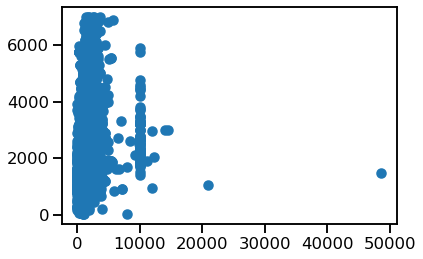

In [21]:
plt.scatter(with_sqft.AREA_SQFT, with_sqft.PRICE)

In [22]:
print('Listings with unknown square footage:', sum(with_sqft.AREA_SQFT == 9999))

Listings with unknown square footage: 87


#### It is apparent that 9999 was used as a value for unknown square footages. There are a number of outliers as well.

In [23]:
without_sqft = without_sqft.append(with_sqft[with_sqft.AREA_SQFT == 9999])

with_sqft = with_sqft[with_sqft.AREA_SQFT != 9999]

print('Rows with square footage:', with_sqft.shape[0])
print('Rows without square footage:', without_sqft.shape[0])

Rows with square footage: 52540
Rows without square footage: 74314


In [24]:
z = np.abs(stats.zscore(with_sqft.AREA_SQFT))
outlier_mask = z < 3

with_sqft = with_sqft[outlier_mask]
with_sqft.shape

(52050, 5)

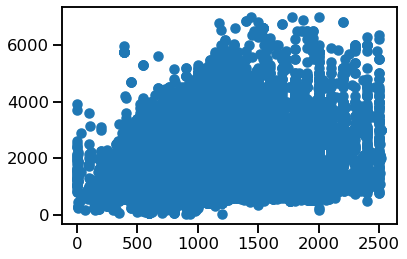

In [25]:
plt.scatter(with_sqft.AREA_SQFT, with_sqft.PRICE)

In [26]:
sum(with_sqft.AREA_SQFT == 0)

6

In [27]:
with_sqft = with_sqft[with_sqft.AREA_SQFT != 0]

In [28]:
with_sqft.shape

(52044, 5)

<AxesSubplot:xlabel='AREA_SQFT'>

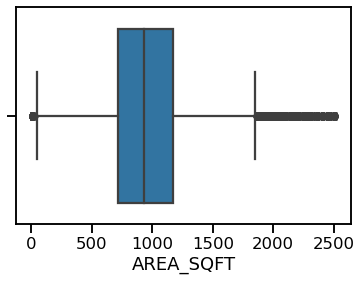

In [29]:
sns.boxplot(x=with_sqft.AREA_SQFT)

In [30]:
median_sqft = np.median(with_sqft.AREA_SQFT)

In [31]:
without_sqft.AREA_SQFT = median_sqft

In [32]:
without_sqft.head()

,BODY,PRICE,AREA_SQFT,ALLOWS_CATS,ALLOWS_DOGS
LISTING_ID,,,,,
7075241085,Big 4 Bedroom Fully Renovated off Shrewsbury S...,1550,930.0,1.0,1.0
7075365895,PROPERTY INFO ID: 32252343Rent: 2350 / MonthBe...,2350,930.0,1.0,0.0
7075367288,PROPERTY INFO ID: 32252343Rent: 2350 / MonthBe...,2350,930.0,1.0,0.0
7080724747,MustSeeProperties.com provides the Complete Pa...,795,930.0,0.0,0.0
7080726002,Our Goal: Provide You With the Best. If you ca...,795,930.0,0.0,0.0


In [33]:
listings_df = with_sqft.append(without_sqft)

In [34]:
listings_df.shape

(126358, 5)

In [35]:
listings_df.head()

,BODY,PRICE,AREA_SQFT,ALLOWS_CATS,ALLOWS_DOGS
LISTING_ID,,,,,
7075306172,PROPERTY INFO ID: 32252124Rent: 2275 / MonthBe...,2275,900.0,1.0,0.0
7075321793,PROPERTY INFO ID: 1281339Rent: 2350 / MonthBed...,2350,800.0,1.0,0.0
7075372720,PROPERTY INFO ID: 2741631Rent: 2395 / MonthBed...,2395,875.0,1.0,0.0
7075376264,PROPERTY INFO ID: 2741631Rent: 2395 / MonthBed...,2395,875.0,1.0,0.0
7075380613,PROPERTY INFO ID: 9826244Rent: 2450 / MonthBed...,2450,950.0,1.0,0.0


In [36]:
listings_df.tail()

,BODY,PRICE,AREA_SQFT,ALLOWS_CATS,ALLOWS_DOGS
LISTING_ID,,,,,
7117153392,"PROPERTY INFO ID: 206339206Rent: $2,650 / Mont...",2650,930.0,1.0,1.0
7117216017,"PROPERTY INFO ID: 206327268Rent: $1,775 / Mont...",1775,930.0,1.0,0.0
7164609101,This apartment is on a dead end st right off H...,2000,930.0,0.0,0.0
7179598931,North End Waterfront studio in a great locatio...,2100,930.0,0.0,0.0
7182439498,Beautifully remodeled 2 bedroom apartment in H...,1975,930.0,0.0,0.0


(array([  229.,  1103.,  5912., 11551., 12721., 15631., 21481., 14597.,
        14075.,  9036.,  5836.,  4342.,  3237.,  2232.,  1605.,   686.,
          682.,   519.,   235.,   200.,   141.,   144.,    69.,    57.,
           37.]),
 array([  10. ,  289.6,  569.2,  848.8, 1128.4, 1408. , 1687.6, 1967.2,
        2246.8, 2526.4, 2806. , 3085.6, 3365.2, 3644.8, 3924.4, 4204. ,
        4483.6, 4763.2, 5042.8, 5322.4, 5602. , 5881.6, 6161.2, 6440.8,
        6720.4, 7000. ]),
 <BarContainer object of 25 artists>)

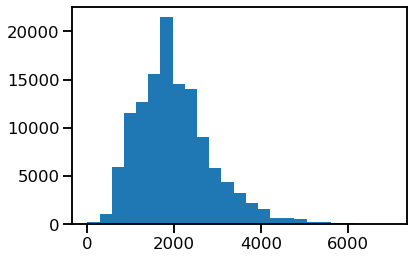

In [37]:
plt.hist(listings_df.PRICE, bins = 25)

<AxesSubplot:xlabel='PRICE'>

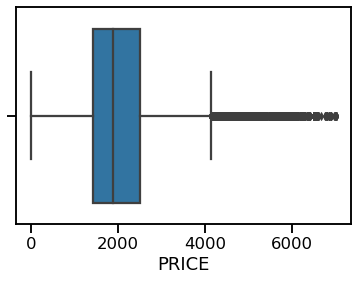

In [38]:
sns.boxplot(x=listings_df.PRICE)

In [39]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126358 entries, 7075306172 to 7182439498
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   BODY         126358 non-null  object 
 1   PRICE        126358 non-null  int64  
 2   AREA_SQFT    126358 non-null  float64
 3   ALLOWS_CATS  126358 non-null  float64
 4   ALLOWS_DOGS  126358 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 5.8+ MB


In [40]:
listings_df.to_csv('..\\data\\wrangled_data.csv')

#### The dataset is now wrangled and ready for engineering!